# The Impact of Music on Task Switching:
## Will Lyrics Exacerbate the Switch Cost?

The main analysis for this experiment is a 2 (transition: switch vs repeat) X 3 (music condition: vocal vs instrumental vs none) within-subjects ANOVA on response times.

*Update*: We're also including block into the design, which is a 2 (block: early vs late) within-subjects factor. So I'll only be reporting the 2 (transition) X 3 (music condition) X 2 (block) ANOVA (not the simpler one without block).

I'll try to direct your attention to the important things you'll need for your method and results as I go. Unless I say something is important, don't pay attention to it. In general, you can ignore the code (unless you're an aspiring data expert).

### General Outline
As per our general analysis philosophy, descriptive statistics and graphs will come before inferential analyses.
* Trial and subject trimming
* Descriptive analyses for:
  * Error rates
  * RTs
* ANOVAs for:
  * Error rates
  * RTs
* Summary of survey data

In [1]:
options(scipen = 999)
library(tidyverse)
library(data.table)
library(ez)
library(xlsx)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v purrr   0.2.4
v tibble  1.4.1     v dplyr   0.7.4
v tidyr   0.7.2     v stringr 1.2.0
v readr   1.1.1     v forcats 0.2.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last

The following object is masked from 'package:purrr':

    transpose

Loading required package: rJava
Loading required package: xlsxjars


In [2]:
current_data <- fread('../data/music_clean.csv')
subject_code <- fread('../data/subject_code.csv')[,1:2]
condition_code <- fread('../data/condition_code.csv')

In [3]:
condition_code

group_id,block,condition
a,1,instrumental
a,2,lyrical
a,3,control
a,4,instrumental
a,5,control
a,6,lyrical
b,1,lyrical
b,2,control
b,3,instrumental
b,4,lyrical


In [4]:
colnames(condition_code)[1] <- 'group'
subject_code <- subject_code %>% 
mutate(subject = as.factor(subject))
current_data <- current_data %>% 
inner_join(subject_code) %>% 
inner_join(condition_code) %>% 
mutate(condition = as.factor(condition),
      transition = ifelse(switch == 1, 'switch', ifelse(switch == 0, 'repeat', ''))) %>% 
select(-group) 

Joining, by = "subject"
Warning message:
"Column `subject` joining character vector and factor, coercing into character vector"Joining, by = c("block", "group")


### Trimming of trials and subjects

We're going to make sure all subjects have error rates less than 15%
* If they don't, we exclude from analysis

We're going to trim some trials based on:
* RT outliers (for RT analyses only)
* Error trials and trials following error trials (for RT analyses only)
* First trials in each block (no transition in first trial of block)

In [5]:
bad_subjects <- current_data %>% 
group_by(subject) %>% 
summarize(error = mean(error)) %>% 
filter(error > .15)
bad_subjects

subject,error
10,0.5021368
11,0.1944444
12,0.2200855
13,0.5149573
14,0.1581197
16,0.1816239
20,0.7200855
21,0.3461538
29,0.5256410
3,0.1965812


Error rates this high are pretty uncommon. Let's stop to do a descriptive analysis on these error rates. I'm going to exclude everyone above 25%, because that's just ridiculous. Let's see if we can figure out why / when so many people are making errors.

### Impromptu Error Analysis
We didn't plan on taking this close of a look at errors going into the analysis, but since errors seemed to be highly prevalent, we'll see what's going on. I'm dropping all subjects above 25% errors first, then looking at the descriptive statistics broken down by the full design. In the final analysis section is where I'll report the ANOVA for these error data.

**Filter out the subjects with > 25% error rates:**

In [6]:
bad_subjects <- current_data %>% 
group_by(subject) %>% 
summarize(error = mean(error)) %>% 
filter(error > .25)
bad_subjects

N <- current_data %>% 
group_by(subject) %>% 
summarize(n()) %>% 
nrow()
paste0('Total N is ',N,', number of subjects above error threshold is ', nrow(bad_subjects), ', ', 
       N - nrow(bad_subjects), ' subjects retained for analysis.')

subject,error
10,0.5021368
13,0.5149573
20,0.7200855
21,0.3461538
29,0.5256410
5,0.5106838
7,0.5299145


[1] "Total N is 28, number of subjects above error threshold is 7, 21 subjects retained for analysis."

You'll want to report the error threshold (25%) and how many subjects were excluded because of it (7).

In [7]:
## getting rid of error subjects
current_data <- current_data[!(current_data$subject %in% bad_subjects$subject),]

It's possible that subjects are either getting better with practice (making fewer errors as they go), or they're getting tired (making more errors as they go). We'll plot error rate as a function of subject, condition, and block.

Block,Condition,error_rate,se
early,control,0.1288156,0.01099579
early,instrumental,0.1385836,0.01444579
early,lyrical,0.1367521,0.00962386
late,control,0.1196581,0.01201151
late,instrumental,0.1294261,0.01193212
late,lyrical,0.1404151,0.01249514


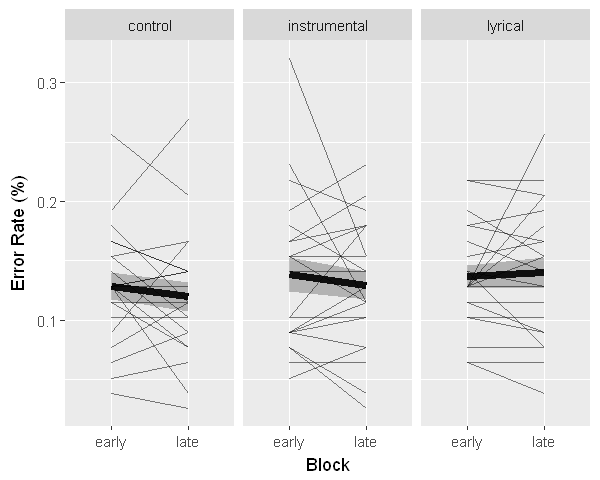

In [8]:
options(repr.plot.width = 5, repr.plot.height = 4)
subject_means <- current_data %>% 
mutate(block_d = factor(ifelse(block < 4, 'early', 'late'))) %>% 
group_by(subject, block_d, condition) %>% 
summarize(error = mean(error))

cell_means <- subject_means %>% 
group_by(Block = block_d, Condition = condition) %>% 
summarize(error_rate = mean(error), se = sd(error) / sqrt(n())) 

cell_means

cell_means %>% 
rename(block_d = Block, condition = Condition) %>% 
ggplot(aes(x = block_d, y = error_rate, group = 1)) + 
geom_line(size = 2) + 
geom_ribbon(aes(ymin = error_rate - se, ymax = error_rate + se), alpha = .3) +
geom_line(data = subject_means, aes(x = block_d, y = error, group = subject), alpha = .5) + 
facet_wrap(~condition) +
theme(legend.position = 'none') + xlab('Block') + ylab('Error Rate (%)')

Error rates seem to decrease slightly across blocks for the control and instrumental conditions, but for lyrical error rates increase slightly or remain the same. My sense is that some people just got the keys wrong at some points.

The graph above doesn't take transition into consideration, however. Below I'll output the means and graph for error rates broken down by the full design (including transition).

condition,transition,Block,Error Rate (Mean),Error Rate (SE)
control,repeat,early,0.1063509,0.01282452
control,repeat,late,0.1004741,0.01310627
control,switch,early,0.1500850,0.01450746
control,switch,late,0.1381907,0.01765882
instrumental,repeat,early,0.1163953,0.01317018
instrumental,repeat,late,0.1197273,0.01436433
instrumental,switch,early,0.1589485,0.02054473
instrumental,switch,late,0.1418177,0.01653885
lyrical,repeat,early,0.1237938,0.01134526
lyrical,repeat,late,0.1207749,0.01304317


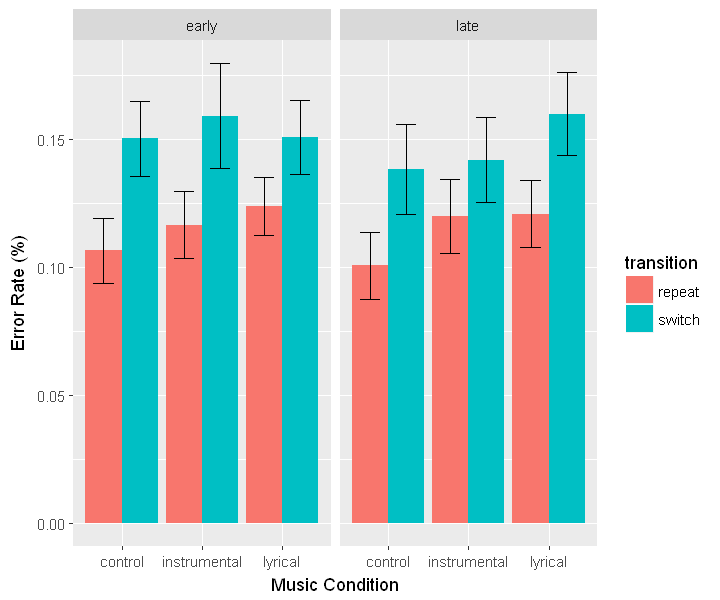

In [9]:
options(repr.plot.width = 6, repr.plot.height = 5)
current_data <- current_data %>% 
mutate(block_d = factor(ifelse(block < 4, 'early', 'late')))

error_summary <- current_data %>% 
group_by(subject, condition, transition, block_d) %>% 
summarize(error = mean(error)) %>% 
group_by(condition, transition, Block = block_d) %>% 
summarize('Error Rate (Mean)' = mean(error), 'Error Rate (SE)' = sd(error) / sqrt(n()))

error_summary

error_summary %>% 
rename(error = 'Error Rate (Mean)', se = 'Error Rate (SE)', block_d = Block) %>% 
ggplot(aes(x = condition, y = error, group = transition)) + 
geom_bar(stat = 'identity', aes(fill = transition), position = 'dodge') +
geom_errorbar(aes(ymin = error - se, ymax = error + se), position = position_dodge(width = .9), width = .5) + 
ylab('Error Rate (%)') + xlab('Music Condition') + facet_wrap(~ block_d)


Naively looking at these trends might lead one to believe there might be a main effect of condition.. ? Switch costs actually appear to be somewhat smaller in the musical conditions perhaps. Only inferential analyses will tell.

Enough with my qualitative musings. 

## Response Time Data

Let's look at the data broken down the same way but for RTs (after removing error trials and RT outliers). I'll run through the RT data similarly to how I did the error data:
* Trimming
* Means & Plots
  * Only by block and condition
  * By the full design

In [10]:
error_data <- current_data

before_trimming <- nrow(current_data)

rt_stats <- current_data %>% 
group_by(subject) %>% 
summarize(rt_mean = mean(rt), rt_sd = sd(rt))

current_data <- current_data %>% 
inner_join(rt_stats) %>% 
filter(error == 0 & shift(error) == 0,
      rt < rt_mean + 2 * rt_sd & rt > rt_mean - 2 * rt_sd) %>% 
select(-rt_mean, -rt_sd)

after_trimming <- nrow(current_data)
paste0('Trimming trials according to errors and response times resulted in the loss of ',
       round((1 - (after_trimming / before_trimming)) * 100, 2),
      '% of the data')

Joining, by = "subject"


[1] "Trimming trials according to errors and response times resulted in the loss of 27.58% of the data"

We trimmed RTs according to +/- 2 standard deviations from subject-wise RT means. Basically how this works is:
* Compute, for each subject, the mean and SD for RT
  * For example, maybe subject 1 has a mean RT of 800 ms with SD = 200 ms
* Then, for each subject on each trial, we look and see whether the RT on that trial is more extreme than 2 SDs beyond *that* subject's mean for RTs.
  * If subject 1 had a trial where it took him/her 1375 ms to respond, we would eliminate that trial because it's greater than `2 * 200 + 800`

Block,Condition,RT (Mean),RT (SE)
early,control,1028.7511,41.36138
early,instrumental,978.7655,35.87344
early,lyrical,1008.6654,41.43825
late,control,833.4269,28.44364
late,instrumental,853.3451,26.75586
late,lyrical,870.7443,36.59959


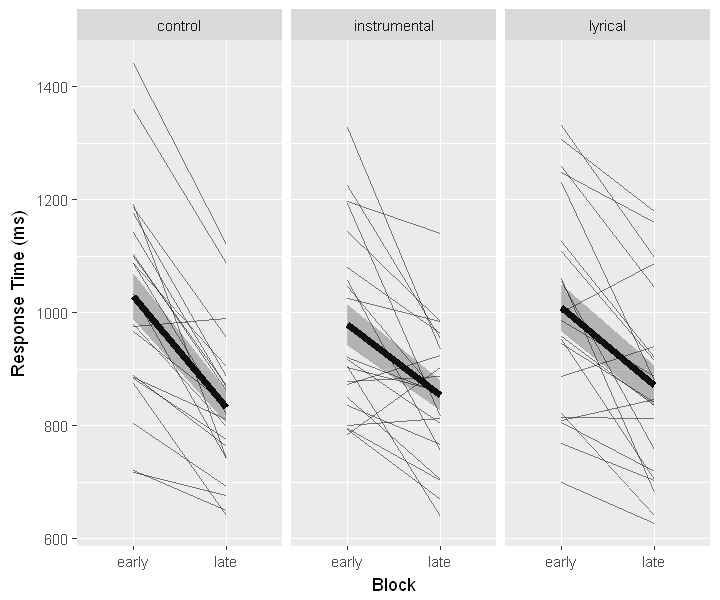

In [11]:
subject_means <- current_data %>% 
mutate(block_d = factor(ifelse(block < 4, 'early', 'late'))) %>% 
group_by(subject, block_d, condition) %>% 
summarize(rt = mean(rt))

cell_means <- subject_means %>% 
group_by(Block = block_d, Condition = condition) %>% 
summarize("RT (Mean)" = mean(rt), 'RT (SE)' = sd(rt) / sqrt(n())) 

cell_means

cell_means %>% 
rename(r_time = "RT (Mean)", se = "RT (SE)", condition = Condition, block_d = Block) %>% 
ggplot(aes(x = block_d, y = r_time, group = 1)) + 
geom_line(size = 2) + 
geom_ribbon(aes(ymin = r_time - se, ymax = r_time + se), alpha = .3) +
geom_line(data = subject_means, aes(x = block_d, y = rt, group = subject), alpha = .5) + 
facet_wrap(~condition) +
theme(legend.position = 'none') + ylab('Response Time (ms)') + xlab('Block')

Unlike error rates, RTs decrease dramatically over blocks, seemingly regardless of condition.  

Let's start to look for the switch cost. We know RTs on switch trials should be longer than that for repeat trials:

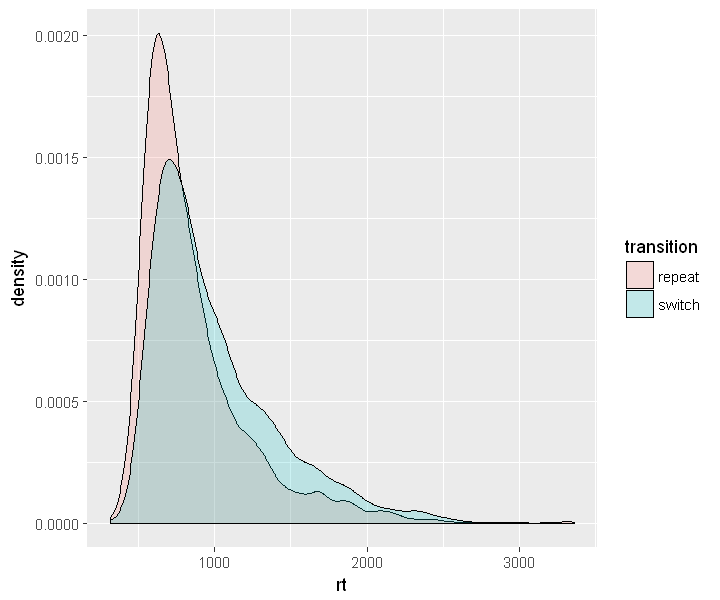

In [12]:
ggplot(current_data, aes(x = rt)) + geom_density(aes(fill = transition), alpha = .2)

What a truly beautiful graph. Now let's output the means and plot for the full design.

## Plotting the Design

We'll plot the 2 (transition: repeat vs switch) X 2 (music condition: control vs lyrical vs instrumental) design predicting RTs.

Condition,Transition,Block,RT (Mean),RT (SE)
control,repeat,early,941.3095,31.35632
control,repeat,late,796.9394,22.93099
control,switch,early,1125.8575,41.70058
control,switch,late,873.5179,28.27631
instrumental,repeat,early,898.7964,24.45280
instrumental,repeat,late,797.8107,22.89242
instrumental,switch,early,1068.0331,39.11460
instrumental,switch,late,906.7497,27.56554
lyrical,repeat,early,913.0164,31.37807
lyrical,repeat,late,807.0102,27.34675


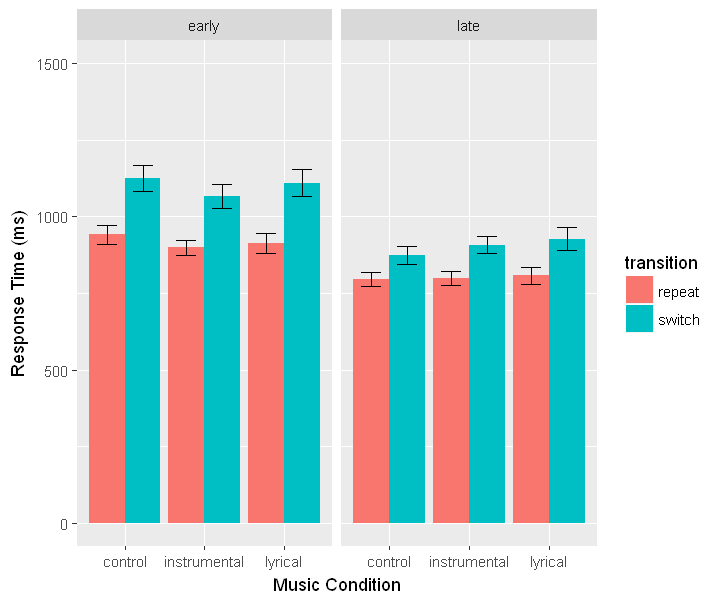

In [13]:
cell_means <- current_data %>% 
group_by(subject, condition, transition, block_d) %>% 
summarize(rt = mean(rt)) %>% 
group_by(Condition = condition, Transition = transition, Block = block_d) %>% 
summarize('RT (Mean)' = mean(rt), 'RT (SE)' = sd(rt) / sqrt(N)) 

cell_means

cell_means %>% 
rename(r_time = "RT (Mean)", se = "RT (SE)", condition = Condition, block_d = Block, transition = Transition) %>% 
ggplot(aes(x = condition, y = r_time, group = transition)) + 
geom_bar(stat = 'identity', aes(fill = transition), position = 'dodge') + 
geom_errorbar(stat = 'identity', aes(ymin = r_time - se, ymax = r_time + se), position = position_dodge(width = .9), width = .5) +
xlab('Music Condition') + ylab('Response Time (ms)') + ylim(0, 1500) + facet_grid(~block_d)

Here, it's easy to see how overall RTs and switch costs decrease over blocks. It really doesn't look like things are varying over blocks, however.

## The ANOVAs

Just to keep the order consistent (and to adhere to what I said in the outline), I'm going to present the error rate ANOVA first. But remember, the RT analysis is the one you were most interested in, at least with respect to what your predictions were.

**ANOVA for error rates**

In [14]:
head(error_data)

subject,block,trial,rt,switch,error,taskcode,condition,transition,block_d
1,1,1,9889,1,1,life,instrumental,switch,early
1,1,2,1439,0,0,life,instrumental,repeat,early
1,1,3,1029,0,0,life,instrumental,repeat,early
1,1,4,766,0,0,life,instrumental,repeat,early
1,1,5,1952,1,0,valence,instrumental,switch,early
1,1,6,1891,1,0,life,instrumental,switch,early


In [27]:
m1 <- error_data %>% 
select(-block) %>% 
rename(block = block_d) %>% 
ezANOVA(data = ., wid = subject, within = .(condition, transition, block), dv = error, detailed = TRUE) 
cbind(m1$ANOVA, n2p = m1$ANOVA$SSn / (m1$ANOVA$SSn + m1$ANOVA$SSd)) %>% 
mutate(p = round(p, 4))

Warning message:
"Converting "subject" to factor for ANOVA."Warning message:
"Converting "transition" to factor for ANOVA."Warning message:
"Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate."

Effect,DFn,DFd,SSn,SSd,F,p,p<.05,ges,n2p
(Intercept),1,20,4.4075624872,0.50237863,175.4677528,0.0000,*,0.7948126797,0.897681333
condition,2,40,0.0099149947,0.08580359,2.3110908,0.1122,,0.0086385392,0.103584840
transition,1,20,0.0786367013,0.12756463,12.3289196,0.0022,*,0.0646425787,0.381358850
block,1,20,0.0011334360,0.04448642,0.5095650,0.4836,,0.0009951313,0.024845237
condition:transition,2,40,0.0009210434,0.12812387,0.1437739,0.8665,,0.0008088062,0.007137387
condition:block,2,40,0.0017208461,0.08679227,0.3965436,0.6753,,0.0015100854,0.019441708
transition:block,1,20,0.0003589641,0.05244087,0.1369024,0.7153,,0.0003153768,0.006798583
condition:transition:block,2,40,0.0028055331,0.11025762,0.5089051,0.6050,,0.0024595842,0.024813859


Alright, so just a main effect of transition. Here are the marginal means for that effect.

In [16]:
error_data %>% 
group_by(subject, block_d, condition, transition) %>% 
summarize(error = mean(error)) %>% 
group_by(transition) %>% 
summarize('Error Rate (Mean)' = mean(error), 'Error Rate (SE)' = sd(error) / sqrt(N)) 

transition,Error Rate (Mean),Error Rate (SE)
repeat,0.1145861,0.01114912
switch,0.1499159,0.01433918


**ANOVA for RTs**

In [26]:
m2 <- current_data %>% 
select(-block) %>% 
rename(block = block_d) %>% 
ezANOVA(data = ., wid = subject, within = .(condition, transition, block), dv = rt, detailed = TRUE)
cbind(m2$ANOVA, n2p = m2$ANOVA$SSn / (m2$ANOVA$SSn + m2$ANOVA$SSd)) %>% 
mutate(p = round(p,4))

Warning message:
"Converting "subject" to factor for ANOVA."Warning message:
"Converting "transition" to factor for ANOVA."Warning message:
"Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate."

Effect,DFn,DFd,SSn,SSd,F,p,p<.05,ges,n2p
(Intercept),1,20,218208926.693,4366607.51,999.4437386,0.0000,*,0.9689728157,0.98038146
condition,2,40,21340.989,1007548.77,0.4236220,0.6576,,0.0030449966,0.02074176
transition,1,20,1284503.374,162413.25,158.1771628,0.0000,*,0.1552888248,0.88775217
block,1,20,1570062.574,317524.71,98.8938831,0.0000,*,0.1834771613,0.83178277
condition:transition,2,40,8755.189,196312.41,0.8919649,0.4178,,0.0012514641,0.04269416
condition:block,2,40,53407.090,623942.22,1.7119242,0.1935,,0.0075855783,0.07884719
transition:block,1,20,104590.817,85638.26,24.4261878,0.0001,*,0.0147481494,0.54981508
condition:transition:block,2,40,6185.649,227214.66,0.5444762,0.5844,,0.0008844997,0.02650232


So two main effects (transition and block) and one interaction (transition and block). Here are the marginal means for those effects:

In [18]:
cell_means <- current_data %>% 
group_by(subject, block_d, condition, transition) %>% 
summarize(rt = mean(rt))

cell_means %>% 
group_by(Transition = transition) %>% 
summarize('RT (Mean)' = mean(rt), 'RT (se)' = sd(rt) / sqrt(N))

cell_means %>% 
group_by(Block = block_d) %>% 
summarize('RT (Mean)' = mean(rt), 'RT (se)' = sd(rt) / sqrt(N))

cell_means %>% 
group_by(Transition = transition, Block = block_d) %>% 
summarize('RT (Mean)' = mean(rt), 'RT (se)' = sd(rt) / sqrt(N))

Transition,RT (Mean),RT (se)
repeat,859.1471,28.76814
switch,1001.9369,40.90031


Block,RT (Mean),RT (se)
early,1009.4749,39.39465
late,851.6091,29.44341


Transition,Block,RT (Mean),RT (se)
repeat,early,917.7074,28.96532
repeat,late,800.5868,24.09707
switch,early,1101.2425,40.97190
switch,late,902.6314,31.27611


Here's a plot for the two-way interaction.

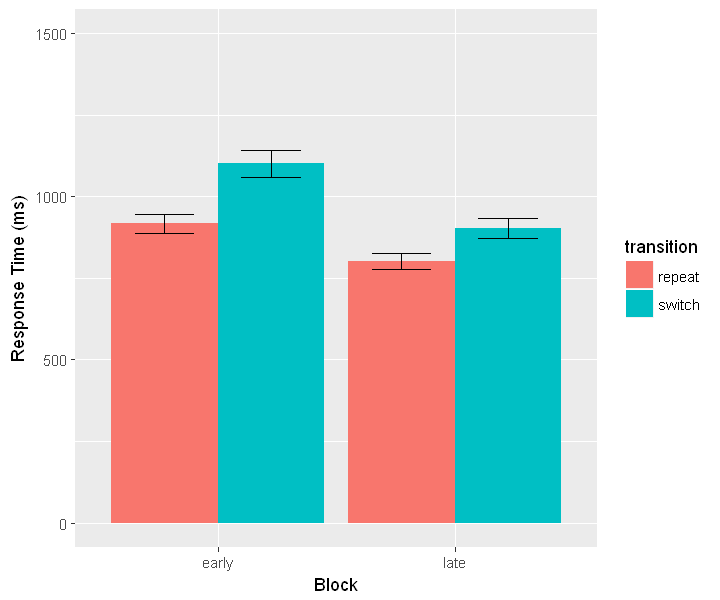

In [19]:
cell_means %>% 
group_by(transition, block_d) %>% 
summarize(r_time = mean(rt), se = sd(rt) / sqrt(N)) %>% 
ggplot(aes(x = block_d, y = r_time, group = transition)) + 
geom_bar(stat = 'identity', aes(fill = transition), position = 'dodge') + 
geom_errorbar(aes(ymin = r_time - se, ymax = r_time + se), position = position_dodge(width = .9), width = .5) + 
xlab('Block') + ylab('Response Time (ms)') + ylim(0, 1500)

## Survey Data
Doing a quick descriptive summary of the survey data. I'm dropping from these data those subjects that we dropped for the main analysis.

In [20]:
survey <- fread('../data/survey_results.csv')
survey <- survey[complete.cases(survey)]
survey <- survey[!(subject %in% bad_subjects$subject)]

In [21]:
head(survey)

subject,personality,driving,studying
1,6,7,3
2,5,7,4
3,5,7,2
4,6,7,6
6,3,6,5
8,5,7,7


In [22]:
survey_summary <- survey %>% 
gather(question, rating, personality:studying) %>% 
mutate(question = as.factor(question)) %>% 
group_by(question, rating) %>% 
summarize(density = n()) %>% 
arrange(question, rating) %>% 
spread(rating, density) %>% 
replace(., is.na(.), 0)

survey_summary

question,1,2,3,4,5,6,7
driving,0,0,0,1,0,5,15
personality,0,3,5,0,8,5,0
studying,1,2,6,2,4,3,3


The table above shows how many reponses were given under each rating for each question.  
I originally plotted these data in a density plot that looked like this:

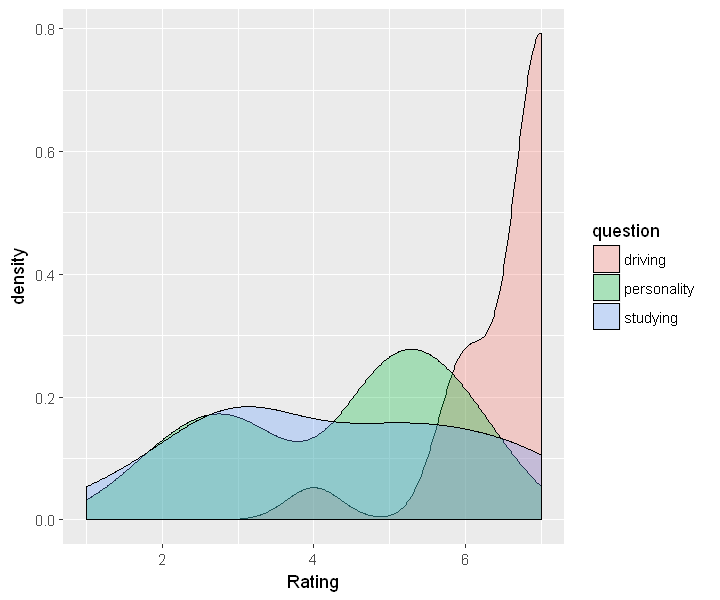

In [23]:
survey %>% 
gather(question, rating, personality:studying) %>% 
ggplot(aes(x = rating)) + geom_density(aes(fill = question), alpha = .3) + xlab('Rating')

But you'll notice the y-axis is different. The following graph more literally depicts the count of each observation of each rating, but (in my opinion) makes interpreting the distribution more difficult.

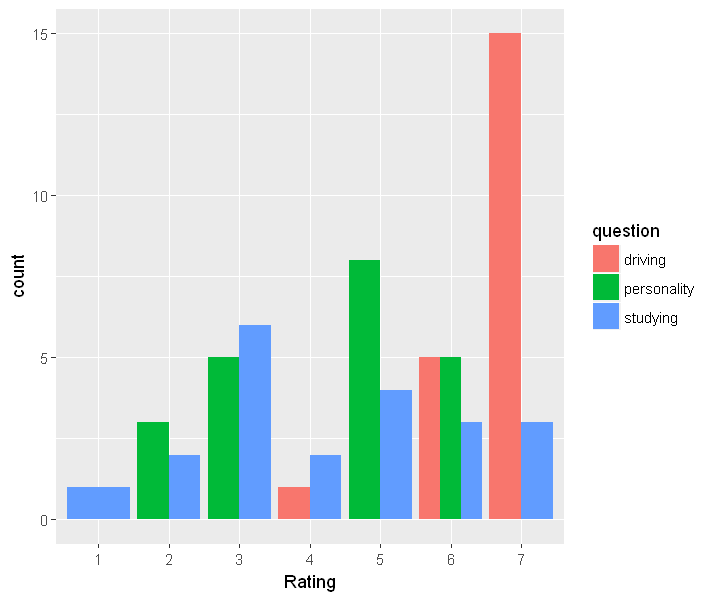

In [24]:
survey %>% 
gather(question, rating, personality:studying) %>% 
ggplot(aes(x = factor(rating))) + geom_bar(aes(fill = question), position = 'dodge') + xlab('Rating')


Scores tended to be pretty uniform for both personality and studying, but most people seem to listen to music while driving.

## Data Access
If you guys want to access the data to do stuff to it yourselves, everything is in the `data` folder inside your guys' main folder on OSF. More specfically: `./Music Group/data/`
* `survey_results.txt` -- the survey data that's plotted immediately above
* `subject_means.xlsx` -- a cleaned dataset with the full design by subject in excel

In [25]:
library(reshape2)
current_data %>% 
group_by(subject, block_d, condition, transition) %>% 
summarize(rt = mean(rt)) %>% 
dcast(subject ~ block_d + condition + transition, value.var = 'rt') %>% 
mutate(subject = as.numeric(subject)) %>% 
arrange(subject) %>% 
write.xlsx('../data/subject_means.xlsx', row.names = FALSE) 
write.table(survey_summary, '../data/survey_results.txt', row.names = FALSE)


Attaching package: 'reshape2'

The following objects are masked from 'package:data.table':

    dcast, melt

The following object is masked from 'package:tidyr':

    smiths

